# PIT - Práctica 2: Detección de Actividad de Voz (II)

**Alicia Lozano Díez**
 
29 de abril de 2021


## Objetivo

El objetivo de esta práctica es explorar la configuración del detector de actividad de voz (VAD) basado en redes neuronales recurrentes (LSTM) de la práctica anterior y realizar una evaluación del rendimiento sobre un conjunto de validación separado del de entrenamiento. Además, se ampliará la arquitectura de dicho modelo con redes convolucionales para procesar directamente la señal _raw_ en lugar de las características MFCC.

### Materiales

- Guión y código (.ipynb) de la práctica - Moodle
- Datos y etiquetas de validación * - One Drive (https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/EWBjWyX774pLhJc2ahr4zk0BtLvWt7YGhdMDDmGu-LcBNQ?e=sbgtjF)
- Lista de validación y script de descarga de datos - Moodle
- Artículo: https://repositorio.uam.es/bitstream/handle/10486/675731/feature_zazo_INTERSPEECH_2016.PDF?sequence=1&isAllowed=y

**CUIDADO: * Los datos proporcionados son de uso exclusivo para esta práctica. No tiene permiso para copiar, distribuir o utilizar el corpus para ningún otro propósito.** 



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [ ]:
download = True
DIR = "/content/drive/My Drive/pit/"
if download and not os.path.isdir("data"):
    #from google.colab import drive
    #drive.mount("/content/drive", force_remount = True)
    %cd "$DIR"
    !cp *.lst /content/
    !cp audio_sample_test.wav /content/
    !cp audio_sample_test.mat /content/
    !cp *.sh /content
    %cd /content
    !chmod 755 *.sh
    !./data_download_onedrive_training_VAD.sh
    !./data_download_onedrive_valid_VAD.sh

/content/drive/My Drive/pit
/content
--2021-05-06 10:44:21--  https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/EdCueYU7BpNAuo6BawH8hJAB5rclap745BmsPzXgSPhsgw?download=1
Resolving dauam-my.sharepoint.com (dauam-my.sharepoint.com)... 13.107.136.9
Connecting to dauam-my.sharepoint.com (dauam-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/alicia_lozano_uam_es/Documents/PIT/training_VAD.zip?originalPath=aHR0cHM6Ly9kYXVhbS1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9hbGljaWFfbG96YW5vX3VhbV9lcy9FZEN1ZVlVN0JwTkF1bzZCYXdIOGhKQUI1cmNsYXA3NDVCbXNQelhnU1Boc2d3P3J0aW1lPVNZS1o2SHNRMlVn [following]
--2021-05-06 10:44:21--  https://dauam-my.sharepoint.com/personal/alicia_lozano_uam_es/Documents/PIT/training_VAD.zip?originalPath=aHR0cHM6Ly9kYXVhbS1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9hbGljaWFfbG96YW5vX3VhbV9lcy9FZEN1ZVlVN0JwTkF1bzZCYXdIOGhKQUI1cmNsYXA3NDVCbXNQelhnU1Boc2d3P3J0aW1lPVNZS1o2SHNRMlVn
Reusing 

# 1. Modificando la configuración y arquitectura del VAD basado en LSTM

## 1.1. Preparación de datos

### Carga de datos de entrenamiento y validación

Como en la práctica anterior, necesitaremos descargar la lista de identificadores de los datos de entrenamiento (fichero **training_VAD.lst** de Moodle, se encuentra en los materiales de la práctica 1):

In [ ]:
file_train_list = 'training_VAD.lst' # mat files containing data + labels
f = open(file_train_list, 'r')
train_list = f.read().splitlines()
TRAIN_PATH = 'data/training_VAD/'
f.close()

Para este conjunto de datos, descargaremos la lista de identificadores **valid_VAD.lst** de Moodle, dentro de los materiales de la práctica 2, así como el fichero de descarga de datos **data_download_onedrive_valid_VAD.sh**:

In [ ]:
file_valid_list = 'valid_VAD.lst' # mat files containing data + labels
f = open(file_valid_list, 'r')
valid_list = f.read().splitlines()
VALID_PATH = 'data/valid_VAD/'
f.close()

### Extracción de características y etiquetas

In [ ]:
def get_feat(segment, rand_idx, n_features=20):
    data = scipy.io.loadmat(segment)['X']
    if data.shape[0] <= length_segments:
        start_frame = 0
    else:
        start_frame = np.random.permutation(data.shape[0] - length_segments)[0]

    end_frame = np.min((start_frame + length_segments, data.shape[0]))
    rand_idx[segment] = start_frame
    feat = data[start_frame:end_frame, :n_features] # discard D and DD, just 20 MFCCs
    return feat[np.newaxis, :, :]   


def get_lab(segment, rand_idx):
    data = scipy.io.loadmat(segment)['Y']
    start_frame = rand_idx[segment]
    end_frame = np.min((start_frame + length_segments, data.shape[0]))
    labs = data[start_frame:end_frame].flatten()
    return labs[np.newaxis, :]

Establecemos que el formato de codificación de las etiquetas es el asociado a la salida de la sigmoide (sin one-hot encoding).

In [ ]:
SOFTMAX_ENCODING = False

## 1.2. Validación (evaluación) del modelo de la práctica 1

Utilizando las partes del código de la práctica anterior que sean necesarias, vamos a entrenarlo y evaluarlo en el conjunto de datos de validación para establecer dicho resultado como sistema de referencia para las posteriores modificaciones. 

La evaluación sobre el conjunto de validación la puede realizar sólo para la última época o para todas ellas. Tenga en cuenta que si quiere realizar el forward para todos los datos de validación de una vez, necesitará que todas las secuencias sean de la misma longitud. Como aproximación, puede escoger unos pocos segundos de cada fichero como se hace en el entrenamiento.



### Definición del modelo

In [ ]:
class Model_1(nn.Module):
    def __init__(self, feat_dim=20):
        super(Model_1, self).__init__()
        self.lstm = nn.LSTM(feat_dim, 256, batch_first=True, bidirectional=False)
        self.output = nn.Linear(256, 1)

    def forward(self, x):
        out = self.lstm(x)[0]
        out = self.output(out)
        out = torch.sigmoid(out)
        return out.squeeze(-1)

In [ ]:
model = Model_1()
device = torch.device("cuda")
model = model.to(device)
print(model)

Model_1(
  (lstm): LSTM(20, 256, batch_first=True)
  (output): Linear(in_features=256, out_features=1, bias=True)
)


### Funciones de entrenamiento y validación

In [ ]:
from keras.utils.np_utils import to_categorical 

def train_for_epoch(segment_sets, n_features):
    model.train()
    cache_loss = 0.0
    cache_acc = 0.0
    n_elems = 0

    # Loop through batches
    for segment_set in segment_sets:
        rand_idx = {}
        optimizer.zero_grad()

        # Create training batches
        feats_batch = np.vstack(
            [get_feat(TRAIN_PATH + segment, rand_idx, n_features) 
             for segment in segment_set])
        if SOFTMAX_ENCODING:
            labs_batch = np.vstack(
                [to_categorical(
                    get_lab(TRAIN_PATH + segment, rand_idx), 
                    num_classes=2).astype(np.int16) 
                 for segment in segment_set])
        else:
            labs_batch = np.vstack(
                [get_lab(TRAIN_PATH + segment, rand_idx).astype(np.int16) 
                 for segment in segment_set])
            
        # Shuffle the data and place them into Pytorch tensors
        shuffle = np.random.permutation(len(labs_batch))
        labs_batch = torch.tensor(
            labs_batch.take(shuffle, axis=0).astype("float32")).to(device)
        feats_batch = torch.tensor(
            feats_batch.take(shuffle, axis=0).astype("float32")).to(device)

        # Forward the data through the network
        predictions = model(feats_batch)

        # Compute cost
        loss = criterion(predictions, labs_batch)

        # Backward step
        loss.backward()
        optimizer.step()

        # Save stats
        cache_loss += loss.item()
        if SOFTMAX_ENCODING:
            cache_acc += (torch.eq(
            torch.argmax(predictions, dim=2), 
            torch.argmax(labs_batch, dim=2))).sum()
        else:
            cache_acc += (torch.eq(predictions >= 0.5, labs_batch)).sum()
        n_elems += np.prod(predictions.shape[:2])

    epoch_loss = cache_loss/len(segment_sets)
    epoch_acc = cache_acc/n_elems
    
    return epoch_loss, epoch_acc.cpu() 

def validate(segment_sets, n_features):
    model.eval()
    cache_loss = 0.0
    cache_acc = 0.0
    n_elems = 0

    # We don't need gradients for validation
    with torch.no_grad():
        # Loop through batches
        for segment_set in segment_sets:
            rand_idx = {}

            # Create validation batches
            feats_batch = np.vstack(
                [get_feat(VALID_PATH + segment, rand_idx, n_features) 
                for segment in segment_set])
            if SOFTMAX_ENCODING:
                labs_batch = np.vstack(
                    [to_categorical(
                        get_lab(VALID_PATH + segment, rand_idx), 
                        num_classes=2).astype(np.int16) 
                    for segment in segment_set])
            else:
                labs_batch = np.vstack(
                    [get_lab(VALID_PATH + segment, rand_idx).astype(np.int16) 
                    for segment in segment_set])

            # Place data into Pytorch tensors (no shuffle!)
            labs_batch = torch.tensor(labs_batch.astype("float32")).to(device)
            feats_batch = torch.tensor(feats_batch.astype("float32")).to(device)

            # Forward the data through the network
            predictions = model(feats_batch)

            # Compute cost
            loss = criterion(predictions, labs_batch)

            # Save stats
            cache_loss += loss.item()
            if SOFTMAX_ENCODING:
                cache_acc += (torch.eq(
                torch.argmax(predictions, dim=2), 
                torch.argmax(labs_batch, dim=2))).sum()
            else:
                cache_acc += (torch.eq(predictions >= 0.5, labs_batch)).sum()
            n_elems += np.prod(predictions.shape[:2])

        epoch_loss = cache_loss/len(segment_sets)
        epoch_acc = cache_acc/n_elems

    return epoch_loss, epoch_acc.cpu()


def train(first_epoch, num_epochs, n_features=20):
    train_losses, valid_losses, train_accs, valid_accs = [], [], [], []

    for epoch in range(first_epoch, first_epoch + num_epochs):
        # Training phase
        train_loss, train_acc = train_for_epoch(train_segments, n_features)

        # Validation phase
        valid_loss, valid_acc = validate(valid_segments, n_features)

        print(f'[{epoch:02d}] train loss: {train_loss:03f}  '
              f'val loss: {valid_loss:03f}  '
              f'train acc: {train_acc*100:.3f}%  '
              f'val acc: {valid_acc*100:.3f}%')

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

    return train_losses, valid_losses, train_accs, valid_accs

In [ ]:
def plot_learning_curves(train_losses, valid_losses, 
                         train_accs, valid_accs, crop=False):
    epochs = range(1, len(train_losses) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(epochs, train_losses, '-o')
    axs[0].plot(epochs, valid_losses, '-o')
    train = axs[1].plot(epochs, train_accs, '-o', label="Train")
    valid = axs[1].plot(epochs, valid_accs, '-o', label="Valid")

    axs[0].set_title('Learning curves')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_xticks(epochs)
    if crop:
        axs[0].set_ylim(0, 5)

    axs[1].legend(bbox_to_anchor=(1.025, 1), loc='upper left')
    axs[1].set_title('Accuracy evolution')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Acc')
    axs[1].set_xticks(epochs)

    plt.show()

In [ ]:
train_batch_size = 51
train_segments = np.array_split(
    train_list, len(train_list)/train_batch_size)

valid_batch_size = 72
valid_segments = np.array_split(
    valid_list, len(valid_list)/valid_batch_size)

### Entrenar y validar con secuencias de 3 segundos

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
length_segments = 300 
epochs = 4

In [ ]:
train_losses, valid_losses, train_accs, valid_accs = train(1, epochs)

[01] train loss: 0.611144  val loss: 0.504300  train acc: 70.278%  val acc: 79.366%
[02] train loss: 0.453588  val loss: 0.368693  train acc: 80.167%  val acc: 83.486%
[03] train loss: 0.346493  val loss: 0.315954  train acc: 85.300%  val acc: 85.644%
[04] train loss: 0.295835  val loss: 0.287246  train acc: 88.701%  val acc: 88.310%


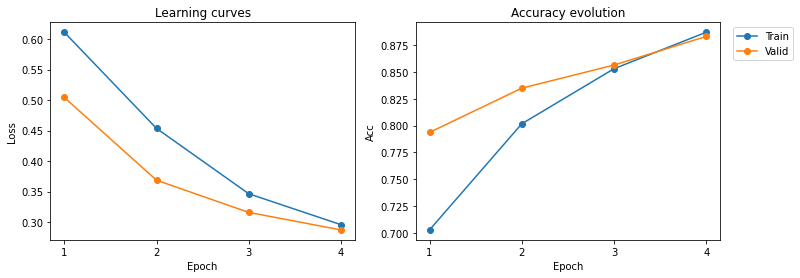

In [ ]:
plot_learning_curves(train_losses, valid_losses, train_accs, valid_accs)

**PREGUNTAS:**
- Incluya en la memoria de la práctica el código utilizado, incluyendo los valores de cualquier parámetro de configuración utilizado (por ejemplo, el número de épocas de entrenamiento realizadas).
- ¿Qué rendimiento (loss y accuracy) obtiene con este modelo (_Model_1_) en entrenamiento y en validación? 


## 1.3. Modificación de la longitud de la secuencia

En este apartado vamos a analizar la influencia de la longitud de la secuencia de datos utilizada para el entrenamiento del modelo. 

En la práctica anterior, las secuencias de entrenamiento que utilizábamos tenían longitud 300 frames, equivalentes a aproximadamente 3 segundos. 

Repita el entrenamiento para secuencias de 1 segundo y 30 segundos. Tenga en cuenta que tal y como está diseñado el código de la práctica anterior, se escogen fragmentos de los audios de dicha longitud al generar los _batches_ y por tanto, variar la longitud de la secuencia, modifica a su vez la cantidad total de audio utilizada para el entrenamiento si mantenemos el número de iteraciones (épocas) con un valor fijo. Modifique el código como corresponda para compensar esto en la medida de lo posible.

### Entrenar y validar con secuencias de 1 segundo

Si 300 frames eran 3 segundos, 100 frames serán 1 segundo (aproximadamente). La cantidad total de frames de audio que considerábamos antes era:

$$
4 \text{ épocas} \cdot 510 \text{ ficheros} \cdot 300 \text{ frames} = 612000 \text{ frames} 
$$

Para compensar por usar secuencias 3 veces más pequeñas, multiplicamos el número de épocas por 3.

In [ ]:
model = Model_1()
device = torch.device("cuda")
model = model.to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
length_segments = 100 
epochs = 12

In [ ]:
train_losses, valid_losses, train_accs, valid_accs = train(1, epochs)

[01] train loss: 0.615211  val loss: 0.554616  train acc: 69.943%  val acc: 77.306%
[02] train loss: 0.494741  val loss: 0.450250  train acc: 78.447%  val acc: 78.819%
[03] train loss: 0.392111  val loss: 0.294333  train acc: 83.214%  val acc: 88.181%
[04] train loss: 0.327881  val loss: 0.330060  train acc: 86.841%  val acc: 85.236%
[05] train loss: 0.350741  val loss: 0.292323  train acc: 85.935%  val acc: 86.833%
[06] train loss: 0.343749  val loss: 0.366775  train acc: 85.235%  val acc: 84.292%
[07] train loss: 0.311317  val loss: 0.317446  train acc: 87.690%  val acc: 88.306%
[08] train loss: 0.306600  val loss: 0.204590  train acc: 87.500%  val acc: 91.847%
[09] train loss: 0.298177  val loss: 0.292616  train acc: 87.588%  val acc: 88.403%
[10] train loss: 0.293822  val loss: 0.201000  train acc: 87.955%  val acc: 92.514%
[11] train loss: 0.279092  val loss: 0.221574  train acc: 88.861%  val acc: 91.750%
[12] train loss: 0.251372  val loss: 0.306742  train acc: 90.314%  val acc: 

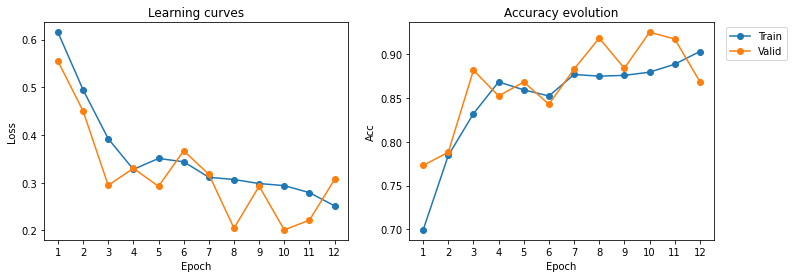

In [ ]:
plot_learning_curves(train_losses, valid_losses, train_accs, valid_accs)

### Entrenar y validar con secuencias de 30 segundos

En este caso estaríamos considerando 10 veces más frames por secuencia, es decir, 3000 frames. Para compensar deberíamos dividir el número de épocas por 10, es decir, hacer solo $0.4$ épocas. La aproximación más cercana es hacer una única época. Además, fijamos el batch_size a 1 para permitir secuencias de distinta longitud, pues hay audios con menos de 30 segundos.

In [ ]:
model = Model_1()
device = torch.device("cuda")
model = model.to(device)

In [ ]:
train_batch_size = 1
train_segments = np.array_split(
    train_list, len(train_list)/train_batch_size)

valid_batch_size = 1
valid_segments = np.array_split(
    valid_list, len(valid_list)/valid_batch_size)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
length_segments = 3000
epochs = 1

In [ ]:
train_losses, valid_losses, train_accs, valid_accs = train(1, epochs)

[01] train loss: 0.275125  val loss: 0.215586  train acc: 88.714%  val acc: 91.264%


**PREGUNTAS**:
- Describa brevemente cómo ha realizado la compensación de datos para poder comparar los modelos de una forma más justa.
- ¿Qué rendimiento obtiene para la red entrenada con secuencias de 1 segundo de longitud sobre el conjunto de validación? ¿Y para la de 30 segundos? Comente brevemente los motivos por los que esto puede ocurrir. 

## 1.4. Redes bidireccionales LSTM

En este apartado, vamos a partir del modelo inicial (_Model_1_) y modificarlo para que la capa LSTM sea bidireccional (_Model_1B_). 

Entrénelo el nuevo modelo con secuencias de longitud 3 segundos y 1 segundo, y compare el resultado con el modelo inicial.


### Definición del nuevo modelo

In [ ]:
class Model_1B(nn.Module):
    def __init__(self, feat_dim=20):
        super(Model_1B, self).__init__()
        self.lstm = nn.LSTM(feat_dim, 256, batch_first=True, bidirectional=True)
        self.output = nn.Linear(2*256, 1)

    def forward(self, x):
        out = self.lstm(x)[0]
        out = self.output(out)
        out = torch.sigmoid(out)
        return out.squeeze(-1)

In [ ]:
model = Model_1B()
device = torch.device("cuda")
model = model.to(device)
print(model)

Model_1B(
  (lstm): LSTM(20, 256, batch_first=True, bidirectional=True)
  (output): Linear(in_features=512, out_features=1, bias=True)
)


### Entrenar y validar con secuencias de 3 segundos

In [ ]:
train_batch_size = 51
train_segments = np.array_split(
    train_list, len(train_list)/train_batch_size)

valid_batch_size = 72
valid_segments = np.array_split(
    valid_list, len(valid_list)/valid_batch_size)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
length_segments = 300
epochs = 4

In [ ]:
train_losses, valid_losses, train_accs, valid_accs = train(1, epochs)

[01] train loss: 0.603703  val loss: 0.504520  train acc: 69.452%  val acc: 77.870%
[02] train loss: 0.414362  val loss: 0.387368  train acc: 82.415%  val acc: 83.306%
[03] train loss: 0.279627  val loss: 0.282866  train acc: 88.236%  val acc: 88.060%
[04] train loss: 0.284049  val loss: 0.228113  train acc: 88.806%  val acc: 91.620%


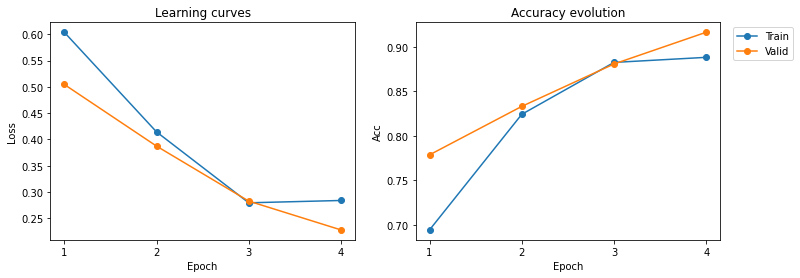

In [ ]:
plot_learning_curves(train_losses, valid_losses, train_accs, valid_accs)

### Entrenar y validar con secuencias de 1 segundo

In [ ]:
model = Model_1B()
device = torch.device("cuda")
model = model.to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
length_segments = 100
epochs = 12

In [ ]:
train_losses, valid_losses, train_accs, valid_accs = train(1, epochs)

[01] train loss: 0.599644  val loss: 0.477672  train acc: 70.602%  val acc: 81.542%
[02] train loss: 0.467635  val loss: 0.401136  train acc: 79.341%  val acc: 84.167%
[03] train loss: 0.353258  val loss: 0.343234  train acc: 85.388%  val acc: 85.208%
[04] train loss: 0.301988  val loss: 0.216296  train acc: 87.480%  val acc: 91.903%
[05] train loss: 0.267260  val loss: 0.228711  train acc: 88.765%  val acc: 90.500%
[06] train loss: 0.261486  val loss: 0.209029  train acc: 89.502%  val acc: 92.500%
[07] train loss: 0.240561  val loss: 0.336130  train acc: 90.904%  val acc: 86.806%
[08] train loss: 0.245377  val loss: 0.272051  train acc: 90.286%  val acc: 88.389%
[09] train loss: 0.286304  val loss: 0.229237  train acc: 87.861%  val acc: 91.472%
[10] train loss: 0.255060  val loss: 0.225692  train acc: 89.722%  val acc: 92.319%
[11] train loss: 0.242943  val loss: 0.247510  train acc: 90.545%  val acc: 89.903%
[12] train loss: 0.223025  val loss: 0.147885  train acc: 91.065%  val acc: 

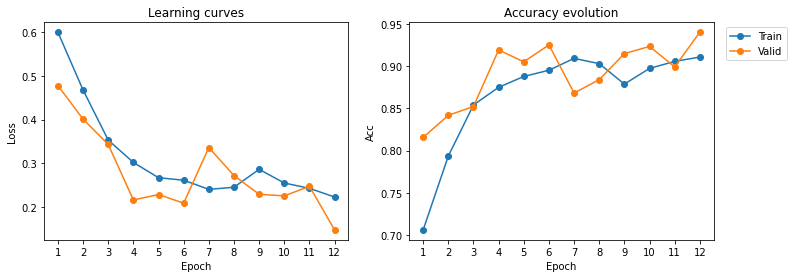

In [ ]:
plot_learning_curves(train_losses, valid_losses, train_accs, valid_accs)


**PREGUNTAS:**
- Explique brevemente la diferencia entre una capa LSTM y una BLSTM (bidirectional LSTM).
- Incluya el código donde define _Model_1B_ en el informe de la práctica.
- ¿Qué modelo obtiene un mejor resultado sobre los datos de validación para las secuencias de 3 segundos? ¿Por qué puede ocurrir esto?
- ¿Y para las secuencias de 1 segundo? ¿Por qué?

## 1.5. Modelo "más profundo"

En este apartado, vamos a partir nuevamente del modelo _Model_1_ y vamos a añadir una segunda capa LSTM tras la primera, con el mismo tamaño y configuración, definiendo un nuevo modelo _Model_2_.

Entrénelo con secuencias de longitud 3 segundos como en el modelo original y compare los resultados.


### Definición del nuevo modelo

In [ ]:
class Model_2(nn.Module):
    def __init__(self, feat_dim=20):
        super(Model_2, self).__init__()
        self.lstm = nn.LSTM(
            feat_dim, 256, num_layers=2, 
            batch_first=True, bidirectional=False)
        self.output = nn.Linear(256, 1)

    def forward(self, x):
        out = self.lstm(x)[0]
        out = self.output(out)
        out = torch.sigmoid(out)
        return out.squeeze(-1)

In [ ]:
model = Model_2()
device = torch.device("cuda")
model = model.to(device)
print(model)

Model_2(
  (lstm): LSTM(20, 256, batch_first=True)
  (lstm2): LSTM(256, 256, batch_first=True)
  (output): Linear(in_features=256, out_features=1, bias=True)
)


### Entrenar y validar con secuencias de 3 segundos

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
length_segments = 300
epochs = 4

In [ ]:
train_losses, valid_losses, train_accs, valid_accs = train(1, epochs)

[01] train loss: 0.569462  val loss: 0.389939  train acc: 73.542%  val acc: 85.199%
[02] train loss: 0.368435  val loss: 0.318452  train acc: 85.699%  val acc: 88.208%
[03] train loss: 0.327291  val loss: 0.338993  train acc: 87.503%  val acc: 87.815%
[04] train loss: 0.290226  val loss: 0.282219  train acc: 89.190%  val acc: 88.852%


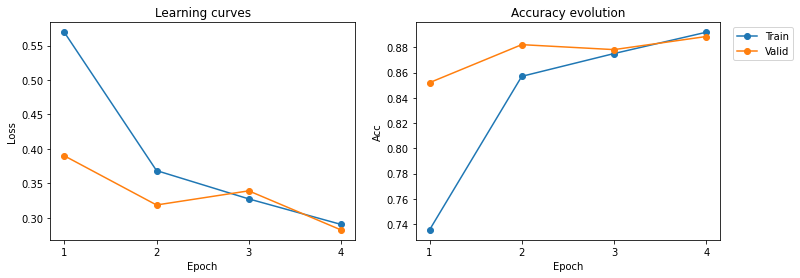

In [ ]:
plot_learning_curves(train_losses, valid_losses, train_accs, valid_accs)


**PREGUNTAS:**
- Incluya el código de la clase _Model_2_ en la memoria.
- ¿Qué modelo obtiene un mejor resultado sobre los datos de validación, _Model_1_ o _Model_2_? ¿Por qué puede ocurrir esto?
- ¿Y con respecto a _Model_1B_, cuál es mejor?

# 2. Convolucional DNN + LSTM

En esta última parte de la práctica, vamos a intentar replicar la definición de las arquitecturas CLDNN y Raw waveform CLDNN del artículo:

Zazo et al., "Feature Learning with Raw-Waveform CLDNNs for Voice Activity Detection", Interspeech 2016.

Estas arquitecturas están definidas en las secciones 2.3 y 2.4 del artículo respectivamente, y combinan redes convolucionales con redes recurrentes.

La siguiente figura muestra la arquitectura:

<img src="https://drive.google.com/uc?export=view&id=1ArwSdl2nmD1d8xjefyLvt_XXHJD4aQfX" width="500">



El resto de detalles se pueden encontrar en el artículo, así como las referencias del mismo.

A continuación, vamos a definir un modelo _Model_CDNN_ que defina la arquitectura CDNN del artículo mencionado, y _Model_CDNN_raw_ con la configuración de la arquitectura _Raw waveform CDNN_.

Estas arquitecturas no van a ser utilizadas para realizar un entrenamiento completo de VAD, pero si necesita comprobar la funcionalidad, puede utilizar cualquiera de los ficheros _WAV_ de la práctica anterior o las características MFCC de esta práctica.

**PREGUNTAS:**
- Incluya el código de las clases _Model_CDNN_ y _Model_CDNN_raw_ en la memoria de la práctica.

## 2.1 Lectura y preparación de datos

### Señal raw

In [ ]:
import scipy.io.wavfile

def read_recording(wav_file_name): 
  fs, signal = scipy.io.wavfile.read(wav_file_name)
  signal = signal/max(abs(signal)) # normalizes amplitude
  
  return fs, signal

In [ ]:
%cd "$DIR"

wav_file = "audio_sample_test.wav"
fs, signal = read_recording(wav_file) 
print("Signal shape: " + str(signal.shape))
print("Sample rate: " + str(fs))

/content/drive/My Drive/pit
Signal shape: (4800160,)
Sample rate: 8000


In [ ]:
from keras.utils.np_utils import to_categorical 

N = 100
M = 1000
signal_batch = signal[np.newaxis, :M]
for i in range(1, N):
    signal_batch = np.vstack((signal_batch, signal[np.newaxis, i*M:(i+1)*M]))
signal_batch = signal_batch[np.newaxis, :, :]

# Set random labels, only to check that the model is correctly built
labels_batch = np.random.randint(2, size=N)[np.newaxis, :]
labels_batch = to_categorical(labels_batch, num_classes=2)

print("Signal shape:", signal_batch.shape)
print("Labels shape:", labels_batch.shape)

Signal shape: (1, 100, 1000)
Labels shape: (1, 100, 2)


### Coeficientes MFCC 

In [ ]:
# Test with only one segment
rand_idx = {}
segment = TRAIN_PATH + train_list[0]
length_segments = 300

# Set appropriate shape
feats_batch = get_feat(segment, rand_idx, n_features=40)
labs_batch = get_lab(segment, rand_idx)  
labs_batch = to_categorical(labs_batch, num_classes=2)  # one-hot encoding for softmax

print("MFCC shape:", feats_batch.shape)
print("Labels shape:", labs_batch.shape)

MFCC shape: (1, 300, 40)
Labels shape: (1, 300, 2)


## 2.2 Modelo CDNN

In [ ]:
class Model_CDNN(nn.Module):
    def __init__(self, P=40, freq_conv_filters=32, n_lstm=1, n_cells=32):
        super(Model_CDNN, self).__init__()
        self.freqConv = nn.Sequential(
            # Convolution along the frequency axis (batch_size, 1, seq_length, P)
            nn.Conv2d(1, freq_conv_filters, kernel_size=(1, 8)),
            nn.MaxPool2d(kernel_size=(1, 3)),  # non-overlapping by default
            nn.ReLU(inplace=True)
        )
        freqConv_output = int((P - 8 + 1)/3)
        self.lstm = nn.LSTM(freq_conv_filters*freqConv_output, n_cells, 
                            batch_first=True, bidirectional=False, 
                            num_layers=n_lstm)
        self.output = nn.Linear(n_cells, 2)

    def forward(self, x):
        """Expected input is (batch_size, seq_length, P)"""
        x_channels = x.unsqueeze(1) # -> (batch_size, 1, seq_length, P)
        out = self.freqConv(x_channels)

        # Flatten frequency values across all channels
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(x.shape[0], x.shape[1], -1)

        out = self.lstm(out)[0]
        out = self.output(out)
        out = nn.Softmax(dim=2)(out)
        
        return out

In [ ]:
model = Model_CDNN()
device = torch.device("cuda")
model = model.to(device)

### Prueba de entrenamiento

In [ ]:
def train_batch(feats_batch, labs_batch):
    model.train()
    optimizer.zero_grad()

    # Place data into Pytorch tensors
    labs_batch = torch.tensor(
        labs_batch.astype("float32")).to(device)
    feats_batch = torch.tensor(
        feats_batch.astype("float32")).to(device)

    # Forward the data through the network
    predictions = model(feats_batch)

    # Compute cost
    loss = criterion(predictions, labs_batch)

     # Backward step
    loss.backward()
    optimizer.step()

    # Save stats
    epoch_loss = loss.item()
    epoch_acc = (torch.eq(
        torch.argmax(predictions, dim=2), 
        torch.argmax(labs_batch, dim=2))).float().mean().cpu()

    print(f'train loss: {epoch_loss:03f}  '
          f'train acc: {epoch_acc*100:.3f}%')
    
    return epoch_loss, epoch_acc

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fast_test = False

if fast_test:
    loss, acc = train_batch(feats_batch, labs_batch)
else:
    SOFTMAX_ENCODING = True

    train_batch_size = 51
    train_segments = np.array_split(
        train_list, len(train_list)/train_batch_size)
    valid_batch_size = 72
    valid_segments = np.array_split(
        valid_list, len(valid_list)/valid_batch_size)

    epochs = 4
    length_segments = 300

    train_losses, valid_losses, train_accs, valid_accs = \
        train(1, epochs, n_features=40)

[01] train loss: 0.663605  val loss: 0.606006  train acc: 60.116%  val acc: 69.412%
[02] train loss: 0.553355  val loss: 0.504591  train acc: 73.720%  val acc: 77.755%
[03] train loss: 0.455373  val loss: 0.464813  train acc: 80.658%  val acc: 79.116%
[04] train loss: 0.413154  val loss: 0.371218  train acc: 82.105%  val acc: 84.523%


## 2.3 Modelo Raw Waveform CDNN

In [ ]:
class Model_CDNN_raw(Model_CDNN):
    def __init__(self, P=40, N=401, freq_conv_filters=16, n_lstm=2, n_cells=16):
        super(Model_CDNN_raw, self).__init__(P, freq_conv_filters, n_lstm, n_cells)
        # Expected input is (batch_size, 1, n_samples)
        self.P = P
        self.timeConv = nn.Sequential(
            nn.Conv1d(1, P, kernel_size=N),
            nn.AdaptiveMaxPool2d(output_size=(None, 1))
        )

    def forward(self, x):
        """Expected input is (batch_size, seq_length, n_samples)"""
        out = np.zeros((x.shape[0], x.shape[1], self.P))  
        out = x.new_tensor(out)  # (batch_size, seq_length, P)

        for i in range(x.shape[1]):
            seq = x[:, i, :].unsqueeze(1)  # (batch_size, 1, n_samples)
            freq_features = self.timeConv(seq).squeeze(-1)
            out[:, i] = torch.log(F.relu(freq_features) + 0.01)
        
        out = super().forward(out)
        
        return out

In [ ]:
model = Model_CDNN_raw()
device = torch.device("cuda")
model = model.to(device)
print(model)

Model_CDNN_raw(
  (freqConv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 8), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
  )
  (lstm): LSTM(176, 16, num_layers=2, batch_first=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
  (timeConv): Sequential(
    (0): Conv1d(1, 40, kernel_size=(401,), stride=(1,))
    (1): AdaptiveMaxPool2d(output_size=(None, 1))
  )
)


### Prueba de entrenamiento

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss, acc = train_batch(signal_batch, labels_batch)

train loss: 0.694333  train acc: 46.000%
